In [1]:
!python3 -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python3 -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

You should consider upgrading via the '/root/miniconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install easydict && pip install tensorboard

  Preparing metadata (setup.py) ... done
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6361 sha256=e2fadbd8dbcfef7f6ff81e690acd278247024a835178aa95412afd29d226aed7
  Stored in directory: /root/.cache/pip/wheels/d3/e0/e9/305e348717e399665119bd012510d51ff4f22d709ff60c3096
Successfully built easydict
You should consider upgrading via the '/root/miniconda3/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 16.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 KB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 38.0 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 KB 32.7 MB

In [2]:
import re, time, os, shutil
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import SimpleITK as sitk  # noqa: N813
import numpy as np
import nibabel as nib
from PIL import Image
from monai.data import create_test_image_3d, list_data_collate, decollate_batch, pad_list_data_collate
import tempfile
import monai
from monai.inferers import sliding_window_inference
from monai.data import ITKReader, PILReader, ImageDataset, DataLoader, Dataset, PersistentDataset, CacheDataset, ArrayDataset
from monai.networks.layers import Norm
from monai.transforms import (
    LoadImage, EnsureChannelFirst, Spacing,
    RandFlip, Resize, EnsureType,
    LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose, ScaleIntensityd, AddChanneld, MapTransform, AsChannelFirstd, EnsureType, Activations, AsDiscrete,
    RandCropByPosNegLabeld, RandRotate90d, LabelToMaskd, RandFlipd, RandRotated, Spacingd, RandAffined
)
#from monai.networks.nets import UNETR
#from torch.utils.tensorboard import SummaryWriter
from monai.transforms.intensity.array import ScaleIntensity
from monai.metrics import DiceMetric
import torch
from monai.config import print_config
#from monai.engines import create_multigpu_supervised_trainer

import torch

print_config()

MONAI version: 0.9.0
Numpy version: 1.19.0
Pytorch version: 1.8.1+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /root/miniconda3/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.1.0
Tensorboard version: 2.9.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-th

In [3]:
!mkdir -p ./MONAI_TMP

In [4]:
os.environ['MONAI_DATA_DIRECTORY'] = "./MONAI_TMP"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./MONAI_TMP


In [5]:
BASE_DIR = '/workspace/RawData/Features'
OUTPUT_DIR = '/workspace/RawData/Features/BIDS'
TMP_DIR = '/workspace/Features/tmp'

In [6]:
!ls /workspace/RawData/Features/prep_wf | wc

    206     206    1613


In [7]:
def assign_feature_maps(sub, feature):
    global BASE_DIR
    global OUTPUT_DIR
    global TMP_DIR
    if feature == 'image':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'sub-{sub}_t1_brain-final.nii.gz')
    elif feature == 't2':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'sub-{sub}_t2_brain-final.nii.gz')
    elif feature == 'blurring-t1':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'Blurring_T1.nii.gz')
    elif feature == 'blurring-Flair':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'Blurring_Flair.nii.gz')
    elif feature == 'cr-t2':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'CR_T2.nii')
    elif feature == 'cr-Flair':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'CR_Flair.nii')
    elif feature == 'thickness':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'thickness_mni.nii')
    elif feature == 'curv':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'curv_mni.nii')
    elif feature == 'sulc':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'sulc_mni.nii')
    elif feature == 'mask':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'sub-{sub}_t1_brain-final_mask.nii.gz')
    return feature_map

In [20]:
"""
images_list = []
subject_list = []
label_list = []

for i in os.listdir(OUTPUT_DIR):
    sub_ind = re.findall('-(.[a-zA-Z0-9]*|[0-9])', str(i))
    if sub_ind:
        subject_list.append(sub_ind[0])
subject_list = ['1', '3', '4', '6', '8']

# [{'image': {'t1w': 't1.nii.gz',
#  'thickness': 'thickness.nii.gz',
#  'curv': 'curv.nii.gz'}
#  'label': '1.nii.gz'}]

# [{'image': 'Images_256/DEAB621C050A_A_mimics.nii',
#   'label': {'label_scapula': 'Masks_scapula_256/DEAB621C050A_A_mimics_scapula.nii',
#    'label_humerus': 'Masks_humerus_256/DEAB621C050A_A_mimics_humerus.nii'}}]


feat_params = ['image', 'thickness', 'curv', 'sulc', 'bluring-T1', 'bluring-T2', 'entropy', 'cr-t1', 'cr-t2']
for sub in subject_list:
    feat_map_per_sub = {}
    feat_map_per_sub['image'] = {}
    for feat in feat_params:
        map_path = assign_feature_maps(sub, feat)
        #if os.path.isfile(map_path):
        feat_map_per_sub['image'][feat] = map_path
        #else:
        #    continue
    #if len(feat_map_per_sub) == 9:
    label_path = os.path.join(BASE_DIR, 'label', f'{sub}.nii.gz')
    feat_map_per_sub['label'] = label_path
    images_list.append(feat_map_per_sub)
"""

"\nimages_list = []\nsubject_list = []\nlabel_list = []\n\nfor i in os.listdir(OUTPUT_DIR):\n    sub_ind = re.findall('-(.[a-zA-Z0-9]*|[0-9])', str(i))\n    if sub_ind:\n        subject_list.append(sub_ind[0])\nsubject_list = ['1', '3', '4', '6', '8']\n\n# [{'image': {'t1w': 't1.nii.gz',\n#  'thickness': 'thickness.nii.gz',\n#  'curv': 'curv.nii.gz'}\n#  'label': '1.nii.gz'}]\n\n# [{'image': 'Images_256/DEAB621C050A_A_mimics.nii',\n#   'label': {'label_scapula': 'Masks_scapula_256/DEAB621C050A_A_mimics_scapula.nii',\n#    'label_humerus': 'Masks_humerus_256/DEAB621C050A_A_mimics_humerus.nii'}}]\n\n\nfeat_params = ['image', 'thickness', 'curv', 'sulc', 'bluring-T1', 'bluring-T2', 'entropy', 'cr-t1', 'cr-t2']\nfor sub in subject_list:\n    feat_map_per_sub = {}\n    feat_map_per_sub['image'] = {}\n    for feat in feat_params:\n        map_path = assign_feature_maps(sub, feat)\n        #if os.path.isfile(map_path):\n        feat_map_per_sub['image'][feat] = map_path\n        #else:\n     

In [8]:
images_list = []
#subject_list = ['1', '3', '4', '6', '8']
#feat_params = ['image', 't2', 'thickness', 'blurring-t1']
feat_params = ['image', 't2', 'mask']
#feat_params = ['t1_raw']
subject_list = []
# {'image': ['/workspace/Features/preprocessed_data/new_pipeline/sub-8/sub-8_acq-T1Mprage_space-MNI152NLint2_seq-T1w_brain.nii.gz',
#   '/workspace/Features/preprocessed_data/thickness/norm-8.nii.gz',
#   '/workspace/Features/preprocessed_data/curv/norm-8.nii.gz',
for i in os.listdir(OUTPUT_DIR):
    sub_ind = re.findall('-(.[a-zA-Z0-9]*|[0-9])', str(i))
    if sub_ind:
        subject_list.append(sub_ind[0])

for sub in subject_list:
    images_per_sub = dict()
    images_per_sub['image'] = []
    for feat in feat_params:
        map_path = assign_feature_maps(sub, feat)
        if os.path.isfile(map_path):
            images_per_sub['image'].append(map_path)
        else:
            continue
    if len(images_per_sub['image']) == len(feat_params):
        #print(f'For subject {sub} all feature files are set')
        seg_path = os.path.join(BASE_DIR, 'preprocessed_data/label_bernaskoni', f'{sub}.nii.gz')
        if os.path.isfile(seg_path):
            images_per_sub['seg'] = seg_path
        else:
            continue
        images_list.append(images_per_sub)

In [ ]:
"""
images_list = []
subject_list = ['1', '3', '4', '6', '8']

# {'image': '/workspace/Features/preprocessed_data/new_pipeline/sub-8/sub-8_acq-T1Mprage_space-MNI152NLint2_seq-T1w_brain.nii.gz',
#  'thickness': '/workspace/Features/preprocessed_data/thickness/norm-8.nii.gz',
#  'curv': '/workspace/Features/preprocessed_data/curv/norm-8.nii.gz',
#  'sulc': '/workspace/Features/preprocessed_data/sulc/norm-8.nii.gz',

for sub in subject_list:
    image_per_sub = dict()
    image_per_sub['image'] = {}
    for feat in feat_params:
        map_path = assign_feature_maps(sub, feat)
        if os.path.isfile(map_path):
            image_per_sub[feat] = map_path
    image_per_sub['seg'] = os.path.join(BASE_DIR, 'label', f'{sub}.nii.gz')
    if os.path.isfile(map_path):
        images_list.append(image_per_sub)
"""

In [10]:
#### JUST IMAGE AND BRAIN MASK

"""
subject_list = []
images_list = []

for i in os.listdir(BASE_DIR + '/fmriprep'):
    if os.path.isdir(os.path.join(BASE_DIR + '/fmriprep', i)):
        sub_ind = re.findall('^sub-(?!C)(.[a-zA-Z0-9]*|[0-9])', str(i))
        if sub_ind:  
            subject_list.append(sub_ind[0])
            t1_per_sub = dict()
            for k in os.listdir(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/'):
                t1_file = re.findall(f'^sub-{sub_ind[0]}_acq.*MNI152NLin2009cAsym_desc-preproc_T1w\.nii\.gz', str(k))
                bm_file = re.findall(f'^sub-{sub_ind[0]}_acq.*MNI152NLin2009cAsym_desc-brain_mask\.nii\.gz', str(k))
                for x in t1_file:
                    t1_per_sub['image'] = os.path.join(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/', x)
                for y in bm_file:
                    t1_per_sub['seg'] = os.path.join(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/', y)
            images_list.append(t1_per_sub)
images_list = [i for i in images_list if i]
"""

"\nsubject_list = []\nimages_list = []\n\nfor i in os.listdir(BASE_DIR + '/fmriprep'):\n    if os.path.isdir(os.path.join(BASE_DIR + '/fmriprep', i)):\n        sub_ind = re.findall('^sub-(?!C)(.[a-zA-Z0-9]*|[0-9])', str(i))\n        if sub_ind:  \n            subject_list.append(sub_ind[0])\n            t1_per_sub = dict()\n            for k in os.listdir(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/'):\n                t1_file = re.findall(f'^sub-{sub_ind[0]}_acq.*MNI152NLin2009cAsym_desc-preproc_T1w\\.nii\\.gz', str(k))\n                bm_file = re.findall(f'^sub-{sub_ind[0]}_acq.*MNI152NLin2009cAsym_desc-brain_mask\\.nii\\.gz', str(k))\n                for x in t1_file:\n                    t1_per_sub['image'] = os.path.join(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/', x)\n                for y in bm_file:\n                    t1_per_sub['seg'] = os.path.join(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/', y)\n            images_list.append(t1_per_sub)\nimages_lis

### images_list also Checks that features and labels available and returns number of available subjects

In [9]:
len(images_list)

197

In [10]:
from sklearn.model_selection import train_test_split
random_seed = 666
train_files, val_files = train_test_split(images_list[:50], shuffle=False, train_size=0.80, random_state=random_seed)
print(len(train_files), len(val_files))

40 10


In [11]:
print(val_files[0])
print(train_files[0])

{'image': ['/workspace/RawData/Features/prep_wf/sub-n66/sub-n66_t1_brain-final.nii.gz', '/workspace/RawData/Features/prep_wf/sub-n66/sub-n66_t2_brain-final.nii.gz', '/workspace/RawData/Features/prep_wf/sub-n66/sub-n66_t1_brain-final_mask.nii.gz'], 'seg': '/workspace/RawData/Features/preprocessed_data/label_bernaskoni/n66.nii.gz'}
{'image': ['/workspace/RawData/Features/prep_wf/sub-76/sub-76_t1_brain-final.nii.gz', '/workspace/RawData/Features/prep_wf/sub-76/sub-76_t2_brain-final.nii.gz', '/workspace/RawData/Features/prep_wf/sub-76/sub-76_t1_brain-final_mask.nii.gz'], 'seg': '/workspace/RawData/Features/preprocessed_data/label_bernaskoni/76.nii.gz'}


In [12]:
### Binarize labels
"""
import nibabel as nib
labels_loc_dir = os.listdir('/workspace/RawData/Features/preprocessed_data/label_bernaskoni')
for lab in labels_loc_dir:
    try:
        img = nib.load(f'/workspace/RawData/Features/preprocessed_data/label_bernaskoni/{lab}')
        array = img.get_fdata().astype(np.float32)
        array_new = array.copy()
        array_new[array > 0.0] = 1.0 
        img_tosave= nib.Nifti1Image(array_new.astype(np.float32), img.affine, img.header)
        nib.save(img_tosave, f'/workspace/RawData/Features/preprocessed_data/label_binarized/{lab}')
    except:
        continue
"""

"\nimport nibabel as nib\nlabels_loc_dir = os.listdir('/workspace/RawData/Features/preprocessed_data/label_bernaskoni')\nfor lab in labels_loc_dir:\n    try:\n        img = nib.load(f'/workspace/RawData/Features/preprocessed_data/label_bernaskoni/{lab}')\n        array = img.get_fdata().astype(np.float32)\n        array_new = array.copy()\n        array_new[array > 0.0] = 1.0 \n        img_tosave= nib.Nifti1Image(array_new.astype(np.float32), img.affine, img.header)\n        nib.save(img_tosave, f'/workspace/RawData/Features/preprocessed_data/label_binarized/{lab}')\n    except:\n        continue\n"

## Transformation and Augmentation

In [12]:
train_transf = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image", "seg"]),
        RandRotated(keys=["image", "seg"], range_x=0.0, range_y=0.0, range_z=0.45, prob=1),
        RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
        Resized(keys=["image", "seg"], spatial_size=(128,128,128), mode=('area', 'nearest')),
        Spacingd(keys=['seg'], pixdim=1.0),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0, channel_wise=True),
        #RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
        #RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=2),
        #RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        #RandRotated(keys=["image", "seg"], range_x=0.0, range_y=0.0, range_z=0.75, prob=1),
        EnsureTyped(keys=["image", "seg"], dtype=torch.float),
    ]
)
val_transf = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image", "seg"]),
        Resized(keys=["image", "seg"], spatial_size=(128,128,128), mode=('area', 'nearest')),
        Spacingd(keys=['seg'], pixdim=1.0),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0, channel_wise=True),
        EnsureTyped(keys=["image", "seg"], dtype=torch.float),
    ]
)

In [13]:
check_dataset = Dataset(data=train_files, transform=train_transf)

In [14]:
check_dataset[0]['seg'].shape

torch.Size([1, 128, 128, 128])

In [15]:
check_dataset[0]['image'].shape

torch.Size([3, 128, 128, 128])

In [16]:
print(torch.cuda.is_available())
torch.cuda.set_device(2)
print(torch.cuda.current_device())

True
2


In [17]:
#check_loader = DataLoader(check_dataset, batch_size=10, num_workers=0, collate_fn=list_data_collate, pin_memory=torch.cuda.is_available())
check_loader = DataLoader(check_dataset, batch_size=4, num_workers=0, collate_fn=list_data_collate, pin_memory=torch.cuda.is_available())

In [18]:
check_data = monai.utils.misc.first(check_loader)

### Check batch size in check_loader and number of 

In [19]:
print(check_data["image"].shape, check_data["seg"].shape)

torch.Size([4, 3, 128, 128, 128]) torch.Size([4, 1, 128, 128, 128])


In [20]:
train_data_example = check_dataset[9]

image shape: torch.Size([3, 128, 128, 128])


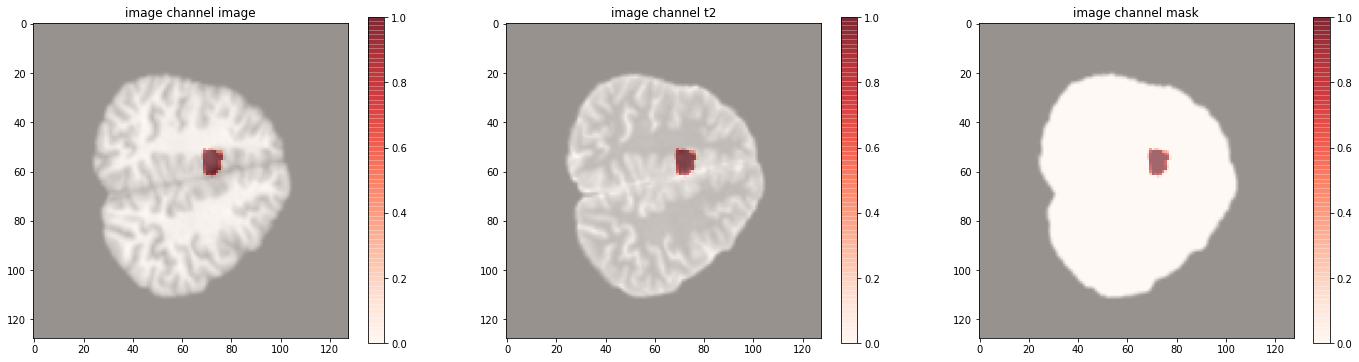

segmentaion shape: torch.Size([1, 128, 128, 128])


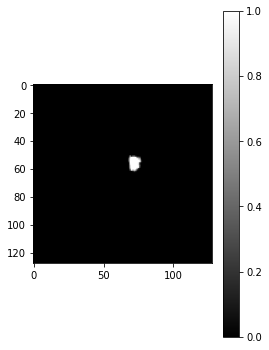

In [21]:
print(f"image shape: {train_data_example['image'].shape}")
num_of_channels = len(feat_params)
label_ind = round(np.where(train_data_example["seg"]>0)[3].shape[0] / 2)
label_pos = np.where(train_data_example["seg"]>0)[3][label_ind]
plt.figure("image", (24, 6))
for i in range(num_of_channels):
    plt.subplot(1, num_of_channels, i + 1)
    plt.title(f"image channel {feat_params[i]}")
    plt.imshow(train_data_example['image'][i, :, :, label_pos], cmap="gray")
    plt.imshow(train_data_example["seg"][0,:, :, label_pos],interpolation='none', cmap='Reds', alpha=0.6)
    plt.colorbar()
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"segmentaion shape: {train_data_example['seg'].shape}")
plt.figure("seg", (4, 6))
plt.imshow(train_data_example["seg"][0,:, :, label_pos], cmap="gray")
plt.colorbar()
plt.show()

In [64]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transf)
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

val_ds = monai.data.Dataset(data=val_files, transform=val_transf)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=0, collate_fn=list_data_collate)

In [65]:
ind = 0
train_files[ind]

{'image': ['/workspace/RawData/Features/prep_wf/sub-76/sub-76_t1_brain-final.nii.gz',
  '/workspace/RawData/Features/prep_wf/sub-76/sub-76_t2_brain-final.nii.gz',
  '/workspace/RawData/Features/prep_wf/sub-76/sub-76_t1_brain-final_mask.nii.gz'],
 'seg': '/workspace/RawData/Features/preprocessed_data/label_bernaskoni/76.nii.gz'}

## Transform random rotate augmentation example

### Before augmentation

[-24. -22. -21. -15.  -8.  -7.   6.]


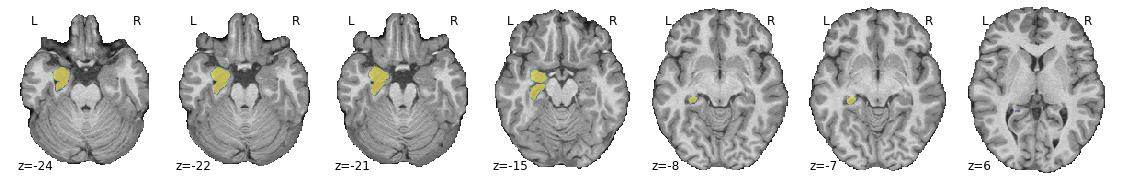

In [57]:
from nilearn.plotting import plot_img
plot_img = plot_img(train_files[ind]['seg'],
         bg_img=train_files[ind]['image'][0],
         threshold=0.1, alpha=0.5, display_mode='z')
plot_img
print(plot_img.cut_coords) # get coordinate of z where lesion center mass

### Augmentation

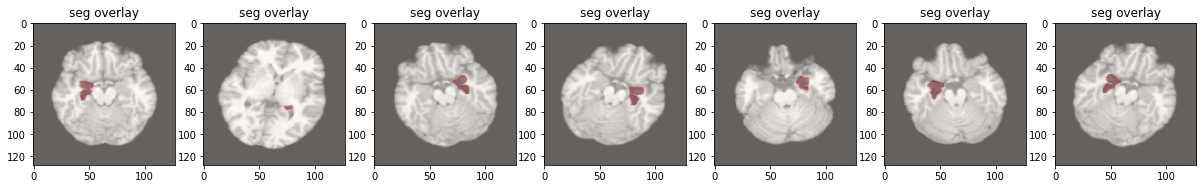

In [58]:
plt.figure(figsize=(30,30))
for i in range(7):
    plt.subplot(1, 10, i+1)
    item = train_loader.dataset[ind]
    image, segme = item["image"], item["seg"]
    lab_loc = round(np.where(segme>0)[3].shape[0] / 2)
    lab_pos = np.where(segme>0)[3][lab_loc]
    plt.imshow(np.rot90(image[0,:, :, lab_pos]), cmap='gray')
    plt.imshow(np.rot90(segme[0,:, :, lab_pos]), cmap="Reds", alpha=0.4)
    plt.title("seg overlay")
plt.show()

In [26]:
a = train_loader.dataset.data[0]['seg'].split('/')[6].split('.')[0]
a

'76'

In [27]:
train_loader.dataset.data[0]['image'][2]

'/workspace/RawData/Features/prep_wf/sub-76/sub-76_t1_brain-final_mask.nii.gz'

In [75]:
def one_epoch(model, 
                criterion, 
                opt, 
                config, 
                dataloader, 
                device, 
                writer, 
                epoch, 
                metric_dict_epoch, 
                n_iters_total=0,
                augmentation=None, 
                is_train=True):


    # use amp to accelerate training
    if config.opt.use_scaler:
        scaler = torch.cuda.amp.GradScaler()

    phase_name = 'train' if is_train else 'val'
    loss_name = config.opt.criterion
    metric_dict = defaultdict(list)
    target_metric_name = config.model.target_metric_name 

    if not is_train:
        model.eval()
    else:
        model.train()

    # used to turn on/off gradients
    grad_context = torch.autograd.enable_grad if is_train else torch.no_grad
    with grad_context():
        iterator = enumerate(dataloader)
        val_predictions = {}
        for iter_i, data_tensors in iterator:
            
            brain_tensor, label_tensor = data_tensors['image'], data_tensors['seg']
            #mask_tensor = brain_tensor
            t1 = time.time()


            brain_tensor = brain_tensor.to(device)
            label_tensor = label_tensor.to(device)
            #mask_tensor = mask_tensor.to(device)

            # forward pass
            with autocast(enabled=config.opt.use_scaler):
                label_tensor_predicted = model(brain_tensor) # -> [bs,1,ps,ps,ps]

                loss = criterion(label_tensor_predicted, label_tensor) 


            if is_train:
                opt.zero_grad()

                if config.opt.use_scaler:
                    scaler.scale(loss).backward()
                else:
                    loss.backward()
                
                if hasattr(config.opt, "grad_clip"):
                    if config.opt.use_scaler:
                        scaler.unscale_(opt)
                        torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                           config.opt.grad_clip)

                metric_dict['grad_norm'].append(calc_gradient_norm(filter(lambda x: x[1].requires_grad, 
                                                model.named_parameters())))

                if config.opt.use_scaler:
                    scaler.step(opt)
                    scaler.update()
                else:
                    opt.step()


            t2 = time.time()    
            dt = t2-t1 # inference time
            
            metric_dict[f'batch_time'].append(dt)
            metric_dict[f'{loss_name}'].append(loss.item())
            #label_tensor_predicted = label_tensor_predicted*mask_tensor
            dice_score = DiceScoreBinary(label_tensor_predicted, label_tensor)
            coverage = (label_tensor_predicted*label_tensor).sum() / label_tensor.sum()
            
            if not is_train:
#                #label = dataloader.dataset.labels[iter_i]
                 #label = dataloader.dataset[iter_i]['seg']
                label = dataloader.dataset.data[iter_i]['seg'].split('/')[6].split('.')[0]
                val_predictions[label] = label_tensor_predicted.detach().cpu().numpy()
            
            metric_dict['coverage'].append(coverage.item())
            metric_dict['dice_score'].append(dice_score.item())
            
            #########
            # PRINT #
            #########
            message = f'For {phase_name}, iter: {iter_i},'
            for title, value in metric_dict.items():
                if title == 'grad_norm':
                    v = np.round(value[-1],6)
                else:
                    v = np.round(value[-1],3)
                message+=f' {title}:{v}'
            print(message)

            # print(f'Epoch: {epoch}, Iter: {iter_i}, \n \
            # Loss_{loss_name}: {loss.item()}, Dice-score: {dice_score.item()}, \n \
            # time: {np.round(dt,2)}-s')

            if is_train and writer is not None:
                for title, value in metric_dict.items():
                    writer.add_scalar(f"{phase_name}_{title}", value[-1], n_iters_total)

            n_iters_total += 1

    target_metric = 0
    for title, value in metric_dict.items():
        m = np.mean(value)
        metric_dict_epoch[phase_name + '_' + title].append(m)
        if title == target_metric_name:
            target_metric = m
        if writer is not None:
            writer.add_scalar(f"{phase_name}_{title}_epoch", m, epoch)
            
    #####################
    # SAVING BEST PREDS #
    #####################
    target_metrics_epoch = metric_dict_epoch[f'val_{target_metric_name}']
    if not is_train:
        if config.dataset.save_best_val_predictions:
            # use greedy-saving: save only if the target metric is improved
            if len(target_metrics_epoch) == 1 or target_metrics_epoch[-1] >= target_metrics_epoch[-2]:
                for label, pred in val_predictions.items():
                        #torch.save(pred, os.path.join(config.dataset.val_preds_path, f'{label}'))
                        torch.save(pred, os.path.join(config.dataset.val_preds_path, f'{label}'))


    return n_iters_total, target_metric

In [70]:
# Plot Image with one epoch iterator

def one_epoch(model, 
                criterion, 
                opt, 
                config, 
                dataloader, 
                device, 
                writer, 
                epoch, 
                metric_dict_epoch, 
                n_iters_total=0,
                augmentation=None, 
                is_train=True):

    plt.figure(figsize=(30,30))
    # use amp to accelerate training
    if config.opt.use_scaler:
        scaler = torch.cuda.amp.GradScaler()

    phase_name = 'train' if is_train else 'val'
    loss_name = config.opt.criterion
    metric_dict = defaultdict(list)
    target_metric_name = config.model.target_metric_name 

    if not is_train:
        model.eval()
    else:
        model.train()

    # used to turn on/off gradients
    grad_context = torch.autograd.enable_grad if is_train else torch.no_grad
    with grad_context():
        iterator = enumerate(dataloader)
        val_predictions = {}
        for iter_i, data_tensors in iterator:
            image, segme = data_tensors['image'], data_tensors['seg']
            
            plt.subplot(1, 11, iter_i+1)
            lab_loc = round(np.where(segme>0)[4].shape[0] / 2)
            lab_pos = np.where(segme>0)[4][lab_loc]
            plt.imshow(image[0, 0,:, :, lab_pos], cmap='gray')
            plt.imshow(segme[0, 0,:, :, lab_pos], cmap="Reds", alpha=0.4)
            plt.imshow(image[0, 2,:, :, lab_pos], cmap="Greens", alpha=0.2)
            #torch.Size([2, 3, 128, 128, 128]) torch.Size([2, 1, 128, 128, 128])
            if iter_i > 10:
                break
            

In [36]:
!pip install configdot tensorboardX celluloid

You should consider upgrading via the '/root/miniconda3/bin/python -m pip install --upgrade pip' command.


In [76]:
import configdot
config = configdot.parse_config('configs/config.ini')

In [77]:
print(config.opt.criterion)

Dice


In [78]:
from datetime import datetime
from tensorboardX import SummaryWriter
from losses import DiceScoreBinary,\
                   DiceLossBinary,\
                   symmetric_focal_loss,\
                sym_unified_focal_loss,\
                symmetric_focal_tversky_loss,\
                DiceSFL,\
                tversky_loss
import torch.optim as optim
from models.v2v import V2VModel
from utils import save, parse_args, get_capacity, calc_gradient_norm
from collections import defaultdict
from IPython.core.debugger import set_trace
import traceback
import torch.nn.functional as F
from torch.cuda.amp import autocast



##########
# LOGDIR #
##########
MAKE_LOGS = config.default.make_logs
SAVE_MODEL = config.opt.save_model if hasattr(config.opt, "save_model") else True
DEVICE = config.opt.device if hasattr(config.opt, "device") else 1
device = torch.device(DEVICE)
print(device)


experiment_name = '{}@{}'.format(config.default.experiment_comment, datetime.now().strftime("%d.%m.%Y-%H"))
print("Experiment name: {}".format(experiment_name))

writer = None
if MAKE_LOGS:
    experiment_dir = os.path.join(config.default.log_dir, experiment_name)
    if os.path.isdir(experiment_dir):
        shutil.rmtree(experiment_dir)
    os.makedirs(experiment_dir)
    shutil.copy('configs/config.ini', os.path.join(experiment_dir, "config.ini"))
    if config.dataset.save_best_val_predictions:
        val_preds_path = os.path.join(experiment_dir, 'best_val_preds')
        config.dataset.val_preds_path = val_preds_path
        os.makedirs(val_preds_path)
    writer = SummaryWriter(os.path.join(experiment_dir, "tb"))
    
#########
# MODEL #
#########
if config.model.name == "v2v":
    model = V2VModel(config).to(device)
elif config.model.name == "unet3d":
    model = UnetModel(config).to(device)
capacity = get_capacity(model)

print(f'Model created! Capacity: {capacity}')

if hasattr(config.model, 'weights'):
    model_dict = torch.load(os.path.join(config.model.weights, 'checkpoints/weights.pth'))
    print(f'LOADING from {config.model.weights} \n epoch:', model_dict['epoch'])
    model.load_state_dict(model_dict['model_state'])


################
# CREATE OPTIM #
################
criterion = {
    "BCE":torch.nn.BCELoss, # [probabilities, target]
    "Dice":DiceLossBinary,
    "DiceBCE":None,
    "DiceSFL": DiceSFL(delta=config.opt.delta, gamma=config.opt.gamma),
    "TL": tversky_loss(delta=config.opt.delta),
    "FTL": symmetric_focal_tversky_loss(delta=config.opt.delta, gamma=config.opt.gamma),
    "SFL": symmetric_focal_loss(delta=config.opt.delta, gamma=config.opt.gamma),
    "USFL":sym_unified_focal_loss(weight=config.opt.weight, # 0.5
                                     delta=config.opt.delta,  # 0.6
                                     gamma=config.opt.gamma) # 0.5
}[config.opt.criterion]
opt = optim.Adam(model.parameters(), lr=config.opt.lr)

#####################
# ASSIGN DATALOADER #
#####################
train_dataloader = train_loader
val_dataloader = val_loader

#item = train_loader.dataset[ind]
#image, segme = item["image"], item["seg"]

cuda:2
Experiment name: v2v-AUG-autocast_DICE-loss_t1+t2@21.06.2022-14
Model created! Capacity: 11.73


In [133]:
model

V2VModel(
  (front_layers): Sequential(
    (0): Basic3DBlock(
      (block): Sequential(
        (0): Conv3d(3, 16, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
        (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): Res3DBlock(
      (res_branch): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (skip_con): Sequential(
        (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fals

In [ ]:
print('Start training!')
metric_dict_epoch = defaultdict(list)
n_iters_total_train = 0 
n_iters_total_val = 0
target_metric = 0
target_metric_prev = -1
try:
    for epoch in range(config.opt.start_epoch, config.opt.n_epochs):
        print (f'TRAIN EPOCH: {epoch} ... ')
        n_iters_total_train, _  = one_epoch(model, 
                                        criterion, 
                                        opt, 
                                        config, 
                                        train_dataloader, 
                                        device, 
                                        writer, 
                                        epoch, 
                                        metric_dict_epoch, 
                                        n_iters_total_train,
                                        augmentation=None, # augmentation None because compose in dataloader
                                        is_train=True)

        print (f'VAL EPOCH: {epoch} ... ')
        n_iters_total_val, target_metric = one_epoch(model, 
                                        criterion, 
                                        opt, 
                                        config, 
                                        val_dataloader, 
                                        device, 
                                        writer, 
                                        epoch, 
                                        metric_dict_epoch, 
                                        n_iters_total_val,
                                        augmentation=None,
                                        is_train=False)

        if SAVE_MODEL and MAKE_LOGS:
            if not config.model.use_greedy_saving:
                print(f'SAVING...')
                save(experiment_dir, model, opt, epoch)
            # use greedy-saving: save only if the target metric is improved
            elif target_metric > target_metric_prev:
                print(f'target_metric = {target_metric}, SAVING...')
                save(experiment_dir, model, opt, epoch)
                target_metric_prev = target_metric
except Exception as e:
    print(traceback.format_exc())
    #set_trace()
    # keyboard interrupt
    if MAKE_LOGS:
        np.save(os.path.join(experiment_dir, 'metric_dict_epoch'), metric_dict_epoch)     


Start training!
TRAIN EPOCH: 0 ... 
For train, iter: 0, grad_norm:8629.054447 batch_time:2.997 Dice:0.998 coverage:0.343 dice_score:0.002
For train, iter: 1, grad_norm:2678.201002 batch_time:2.959 Dice:0.997 coverage:0.528 dice_score:0.003
For train, iter: 2, grad_norm:3924.950461 batch_time:3.001 Dice:0.998 coverage:0.634 dice_score:0.002
For train, iter: 3, grad_norm:1070.082046 batch_time:2.973 Dice:0.999 coverage:0.668 dice_score:0.001
For train, iter: 4, grad_norm:2297.355186 batch_time:2.971 Dice:0.997 coverage:0.699 dice_score:0.003
For train, iter: 5, grad_norm:1806.518698 batch_time:2.976 Dice:0.997 coverage:0.652 dice_score:0.003
For train, iter: 6, grad_norm:14124.524011 batch_time:2.978 Dice:0.984 coverage:0.726 dice_score:0.016
For train, iter: 7, grad_norm:1560.013449 batch_time:2.986 Dice:0.998 coverage:0.757 dice_score:0.002
For train, iter: 8, grad_norm:1370.584463 batch_time:3.026 Dice:0.999 coverage:0.714 dice_score:0.001
For train, iter: 9, grad_norm:1237.650609 bat

In [7]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

In [ ]:
parse_tensorboard('/workspace/RawData/FCDNet/logs/v2v-NOAUG-autocast_DICE-loss_mask@17.06.2022-22/tb/events.out.tfevents.1655506733.90346d20369c', 'event')

In [41]:
from monai.losses import DiceLoss

device = torch.device("cuda:2")
max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = monai.networks.nets.SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=1,
    dropout_prob=0.1,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [43]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["seg"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["seg"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300
1/73, train_loss: 0.9996, step time: 7.6338
2/73, train_loss: 0.9951, step time: 1.1643
3/73, train_loss: 0.9969, step time: 1.1656
4/73, train_loss: 0.9974, step time: 1.1578
5/73, train_loss: 0.9972, step time: 1.1599
6/73, train_loss: 0.9975, step time: 1.1531
7/73, train_loss: 0.9990, step time: 1.1503
8/73, train_loss: 0.9986, step time: 1.1463
9/73, train_loss: 0.9980, step time: 1.1550
10/73, train_loss: 0.9991, step time: 1.1491
11/73, train_loss: 0.9998, step time: 1.1350
12/73, train_loss: 0.9958, step time: 1.1638
13/73, train_loss: 0.9994, step time: 1.1471
14/73, train_loss: 0.9992, step time: 1.1457
15/73, train_loss: 0.9973, step time: 1.1537
16/73, train_loss: 0.9945, step time: 1.1624
17/73, train_loss: 0.9932, step time: 1.1666
18/73, train_loss: 0.9990, step time: 1.1506
19/73, train_loss: 0.9982, step time: 1.1539
20/73, train_loss: 0.9978, step time: 1.1560
21/73, train_loss: 0.9988, step time: 1.1419
22/73, train_loss: 0.9983, step time: 1.1

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [33]:
#trainer = create_multigpu_supervised_trainer(model, optimizer, loss_function, None)
#trainer.run(train_ds['image'], max_epochs=max_epochs, epoch_length=2)

In [34]:
val_data = monai.utils.misc.first(val_loader)
print(val_data["image"].shape, val_data["seg"].shape)

torch.Size([2, 4, 128, 128, 128]) torch.Size([2, 1, 128, 128, 128])


In [37]:
val_data["image"][0].type()

'torch.FloatTensor'

In [38]:
val_data["seg"][0].type()

'torch.IntTensor'

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.show()

In [ ]:
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[0]["image"].unsqueeze(0).to(device)
    roi_size = (192, 192, 192)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    num_of_channels = len(feat_params)
    for i in range(num_of_channels):
        plt.subplot(1, num_of_channels, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[0]["image"][i, :, :, int(np.where(val_ds[0]["seg"] == 1)[2][5])].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image

    plt.title(f"label channel {i}")
    plt.imshow(val_ds[0]["seg"][0, :, :, int(np.where(val_ds[0]["seg"] == 1)[2][5])].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.title(f"output channel {i}")
    plt.imshow(val_output[0, :, :, int(np.where(val_ds[0]["seg"] == 1)[2][5])].detach().cpu())
    plt.show()

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr)
trainer = create_multigpu_supervised_trainer(net, opt, fake_loss, None)
trainer.run(fake_data_stream(), max_epochs=max_epochs, epoch_length=2)

In [ ]:
print("image shape:", img_dataset[0][0].shape)
print("label. shape:", img_dataset[0][1].shape)

In [ ]:
dataloader = DataLoader(img_dataset, batch_size=1, shuffle=True, num_workers=0)
for epoch in range(2):
    for i, batch in enumerate(dataloader):
        print(epoch, i, batch.data.numpy().flatten().tolist())